# Pairtools benchmarking

Welcome to pairtools benchmarking. These are the instructions on how to test performance of different software for mapping Hi-C and Hi-C-like methods.
Mapping usually results in the file with mapped pairs, which is then converted into binned matrix format. Pairs format is the "rawest" interpretable type of data after reads.

Reviewing the literature suggests that there are at least 6 methods to map Hi-C and Hi-C-like data. These include:

- **pairtools** is a lightweight Python CLI that extracts and manipulates Hi-C contacts post-alignment. Aslignment can be done by:
    - bwa mem
    - bwa-mem2, ahn optimized version of bwa mem, which [x2-2.5 improves speed over bwa](https://github.com/bwa-mem2/bwa-mem2)

- **chromap** is a [fast alignment tool for chromatin profiles](https://www.nature.com/articles/s41467-021-26865-w), not specialized for Hi-C but [parameterized for a broad range of sequencing data including Hi-C short reads](https://github.com/haowenz/chromap#map-hi-c-short-reads). 

    Does not require separate step of mapping.

- **HiC-Pro** is a [pipeline for Hi-C and DNase-C mapping](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-015-0831-x), "optimized and flexible".

    It calls mapping within. By default, creates the output cooler files with binned data, but the script can be tinkered in order to stop the processing at the step of pairs.  

- **Juicer** is a [platform for analysis of Hi-C data](https://github.com/aidenlab/juicer), which is already adapted to a wide range of cluster types.

    It calls mapping within. Has an option to stop the data processing at the step of pairs, without further construction of binned matrices. 

- **HiCExplorer** is a [broad-range set of tools for processing, normalization, analysis and visualization Hi-C and Hi-C-like methods](https://doi.org/10.1038/s41467-017-02525-w). 

    It [builds Hi-C binned matrix post-alignment with bwa mem](https://hicexplorer.readthedocs.io/en/latest/content/tools/hicBuildMatrix.html#hicbuildmatrix). 

- **FAN-C** is a [set of CLI tools that runs the mapping (bowtie or bwa mem), extracts and manipulates Hi-C contacts](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02215-9). It also has the [tools for data visualization and downstream analysis](https://github.com/vaquerizaslab/fanc).


*We benchmark these programs on one million of representative reads.*
These reads are taken from random replicate from Rao SSP et al., ["Cohesin Loss Eliminates All Loop Domains."](https://pubmed.ncbi.nlm.nih.gov/28985562/), Cell, 2017 Oct 5;171(2):305-320.e24
<br>
Generally, it is useful to assess how much computational time you need per million of reads.
<br>
As long as you have this assessment, you may multiply the size of your experiment by the whole library size (in mlns of reads), because we expect linear growth of computational complexity of reads mapping with library size.


The benchmarking consists of four general steps. If you want to reproduce it, you need to run steps 1 and 2 manually in order to create the working environment, and then use snakemake script to run the benchmarks. 
<br>
You may use the commands form the "3. Run" section to get an understanding how each indiviaul framework works and what parameters can be changed. 
<br>
Note that you need separate run of juicer with single value of --ncores, because it does not support parallel launches (because it writes to the default output).
<br>
Finally, there is a visualization section with a display of all the results that we calcualted on our machines. 

1. [Install software](#1.-Install-software)

2. [Download data and genome](#2.-Download-data-and-genome). 

3. [Run](#3.-Run)

4. [Visualize benchmarks](#4.-Visualize-benchmarks)


## 1. Install software

We will use separate conda environments to install different utilities. Each utility will have its own environment and peth to the binaries.

In [ ]:
%%bash
mkdir ./soft

### pairtools

#### pairtools v1.0.0

In [ ]:
%%bash
conda create -y --prefix soft/pairtools1.0.0 python=3.9 pip
conda activate soft/pairtools1.0.0
pip install cython
pip install git+https://github.com/open2c/pairtools.git@pre0.4.0 
conda install -y -c bioconda "bwa>=0.7.17"

#### bwa-mem2

In [ ]:
%%bash 
conda activate soft/pairtools1.0.0

# bwa-mem2: compile from source (not recommended for general users)

# Get the source
git clone --recursive https://github.com/bwa-mem2/bwa-mem2 soft/bwa-mem2
cd soft/bwa-mem2

# Compile
make

# Exit compilation folder
cd ../../

### chromap

In [ ]:
%%bash
conda create -y --prefix soft/chromap
conda activate soft/chromap
conda install -y -c bioconda -c conda-forge chromap

### HiC-Pro

[HiC-Pro](https://github.com/nservant/HiC-Pro) is a popular software for Hi-C mapping, its now part of nf-core Hi-C pipeline, supports both fragment-based analysis of Hi-C and fragement-free analysis of DNase-based Hi-C.

In [ ]:
%%bash
git clone https://github.com/nservant/HiC-Pro.git soft/HiC-Pro_env/HiC-Pro
conda env create -f soft/HiC-Pro/environment.yml -p soft/HiC-Pro_env
### Working environment will be soft/HiC-Pro_env

conda activate soft/HiC-Pro_env

# Install dependencies
conda install -y -c bioconda bowtie2 samtools pysam numpy scipy bx-python
conda install -y -c r r r-rcolorbrewer r-ggplot2

# Copy prepared config:
cp configs/config-hicpro_install.txt soft/HiC-Pro_env/HiC-Pro/config-install.txt

# Configure and install:
cd soft/HiC-Pro_env/HiC-Pro
make configure
make install

cd ../../../

# Retain only data processing steps with no creating of maps:
sed -i "s/all : init mapping proc_hic merge_persample hic_qc build_raw_maps ice_norm/all : init mapping proc_hic merge_persample #hic_qc build_raw_maps ice_norm/" soft/HiC-Pro_env/HiC-Pro/scripts/Makefile

In [ ]:
%%bash
# Note that the configs should be adjusted for your system:
cp configs/config-hicpro_install.txt soft/HiC-Pro_env/HiC-Pro/config-install.txt
cp configs/config-hicpro.txt soft/HiC-Pro_env/HiC-Pro/config-hicpro.txt

### FAN-C

In [ ]:
%%bash
conda create -y --prefix soft/fanc python=3.9 pip hdf5
conda activate soft/fanc
pip install fanc
conda install -y -c bioconda samtools

### Juicer

In [ ]:
%%bash

conda create -y --prefix soft/juicer
conda activate soft/juicer

conda install -y -c bioconda bwa java-jdk
conda install -y -c conda-forge coreutils

# Download the recommended stable version:
wget https://github.com/aidenlab/juicer/archive/refs/tags/1.6.zip
unzip 1.6.zip
rm 1.6.zip
mv juicer-1.6 soft/juicer-1.6

# Download compile jar files of the stable  version:
wget http://hicfiles.tc4ga.com.s3.amazonaws.com/public/juicer/juicer_tools.1.6.2_jcuda.0.7.5.jar
mv juicer_tools.1.6.2_jcuda.0.7.5.jar soft/juicer-1.6/CPU/scripts/common/juicer_tools.jar

# Copy the scripts to some accessible location:
mkdir -p soft/juicer-1.6/CPU/scripts/
cp -r soft/juicer-1.6/CPU/[^s]* soft/juicer-1.6/CPU/scripts/

### HiCExplorer

In [ ]:
%%bash

conda create -y --prefix soft/hicexplorer python=3.9
conda activate soft/hicexplorer
conda install -y -c bioconda hicexplorer bwa

## 2. Download data and genome

In [ ]:
%%bash

mkdir data

### Download raw data

Test data from Rao et al. 2017, 1 mln pairs: 

In [ ]:
%%bash

fastq-dump -O data --gzip --split-files SRR6107789 --minSpotId 0 --maxSpotId 1000000

In [ ]:
%%bash

# Put the data in accessible folder for juicer: 
mkdir -p data/4juicer/fastq/
mkdir -p data/4juicer/splits/
cp data/SRR6107789_1.fastq.gz data/4juicer/fastq/SRR6107789_R1.fastq.gz
cp data/SRR6107789_2.fastq.gz data/4juicer/fastq/SRR6107789_R2.fastq.gz
cp data/4juicer/fastq/* data/4juicer/splits/

In [ ]:
%%bash

# Put the data in accessible folder for HiC-Pro:
mkdir -p soft/HiC-Pro_env/HiC-Pro/rawdata/sample1
cp data/S*fastq.gz soft/HiC-Pro_env/HiC-Pro/rawdata/sample1/

### Install genome

#### Genomepy installation
will install fasta, bwa and bowtie2 indexes:

In [ ]:
%%bash

# Activate bwa plugin for genomepy:
! genomepy plugin enable bwa bowtie2

In [ ]:
%%bash

# Install hg38 genome by genomepy:
! genomepy install hg38 -g data/

In [ ]:
%%bash

# Restrict the genome:
! cooler digest data/hg38/hg38.fa.sizes data/hg38/hg38.fa DpnII --rel-ids 1 -o data/hg38/hg38.DpnII.bed

#### Build genome index: bwa-mem2

In [ ]:
%%bash 
mkdir data/hg38/index/bwa-mem2/
soft/bwa-mem2/bwa-mem2 index -p data/hg38/index/bwa-mem2/hg38 data/hg38/hg38.fa

#### Build genome index: chromap

In [ ]:
%%bash 
mkdir data/hg38/index/chromap
chromap -i -r data/hg38/hg38.fa -o data/hg38/index/chromap/hg38

## 3. Run

The banchmarking is usually cumbersome, but it can be simplified by snakemake. We provide a Snakemake pipeline that will allow you to benchmark different approaches.

The output of snakemake will consist of resulting Hi-C pairs/maps in `output` folder and benchmarking files in `benchmarks` folder. 
The file names have the information on parameters in their names:



In [ ]:
%%bash

# Running 
snakemake --cores 10

In [ ]:
%%bash

# Cleanup
rm output/*; rm benchmarks/*

## Manual run

You may also run them to test individual steps of the pipeline.

### pairtools

In [ ]:
%%bash

soft/bwa-mem2/bwa-mem2 mem -t 5 -SP data/hg38/index/bwa-mem2/hg38 data/SRR6107789_1.fastq.gz data/SRR6107789_2.fastq.gz | \
    soft/pairtools1.0.0/bin/pairtools parse --nproc-in 5 --nproc-out 5 --drop-sam --drop-seq -c data/hg38/hg38.fa.sizes | \
    soft/pairtools1.0.0/bin/pairtools sort --nproc 5 | \
    soft/pairtools1.0.0/bin/pairtools dedup -p 5 --backend cython \
    -o output/result.pairtools.pairs

### chromap

In [ ]:
%%bash

soft/chromap/bin/chromap --preset hic --low-mem \
    -t 5 -x data/hg38/index/chromap/hg38 -r data/hg38/hg38.fa \
    -1 data/SRR6107789_1.fastq.gz -2 data/SRR6107789_2.fastq.gz -o output/result.chromap.pairs

### HiC-Pro

In [ ]:
%%bash

cd soft/HiC-Pro_env/HiC-Pro
bin/HiC-Pro -i rawdata/ -o output -c config-hicpro.txt

cd ../../../

### FAN-C
Based on [CLI tutorial](https://fan-c.readthedocs.io/en/latest/fanc-executable/fanc-generate-hic/fanc_modular_steps.html):

In [ ]:
%%bash

fanc map -t 5 data/SRR6107789_1.fastq.gz data/hg38/index/bwa/hg38.fa output/fanc-output_1.bam
fanc map -t 5 data/SRR6107789_2.fastq.gz data/hg38/index/bwa/hg38.fa output/fanc-output_2.bam
samtools sort -@ 5 -n output/fanc-output_1.bam -o output/fanc-output_1.sorted.bam
samtools sort -@ 5 -n output/fanc-output_2.bam -o output/fanc-output_2.sorted.bam
fanc pairs output/fanc-output_1.sorted.bam output/fanc-output_2.sorted.bam output/fanc-output.pairs -g data/hg38/hg38.DpnII.bed

### Juicer

In [ ]:
%%bash

soft/juicer-1.6/CPU/juicer.sh -g hg38 -d data/4juicer/ -s DpnII -S early -p data/hg38/hg38.fa.sizes -y data/hg38/hg38.DpnII.bed -z data/hg38/index/bwa/hg38.fa -t 5 -D soft/juicer-1.6/CPU

### HiCExplorer
Based on the example: https://hicexplorer.readthedocs.io/en/latest/content/example_usage.html

Note that it does not procude the pairs, but binned coolers.

In [ ]:
%%bash

hicBuildMatrix --samFiles \
    <(bwa mem -t 4 -A1 -B4 -E50 -L0 data/hg38/index/bwa/hg38.fa data/SRR6107789_1.fastq.gz | samtools view -Shb -) \
    <(bwa mem -t 4 -A1 -B4 -E50 -L0 data/hg38/index/bwa/hg38.fa data/SRR6107789_2.fastq.gz | samtools view -Shb -) \
     --restrictionSequence GATC \
     --danglingSequence GATC \
     --restrictionCutFile data/hg38/hg38.DpnII.bed \
     --threads 4 \
     --inputBufferSize 100000 \
     --QCfolder hicexplorer_tmp \
     -o hicexplorer_output.cool

## 4. Visualize benchmarks

In [1]:
# Check the CPU properties:
import psutil
print(f"{psutil.cpu_count()} CPUs at {psutil.cpu_freq().current:.0f} GHz") 

36 CPUs at 1388 GHz


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['font.family'] = "sans-serif"
figsize_A4 = np.array([11.69, 8.27])
plt.rcParams["figure.figsize"] = figsize_A4.T
plt.rcParams['figure.facecolor']='white'
plt.rcParams['font.size']=16

import glob

In [3]:
## If you start from .csv. file: 
# df = pd.read_csv('benchmarking_1mln.csv')

In [4]:
# If you start from your own benchmarks:
files = glob.glob("benchmarks/*")
print(len(files))

24


In [5]:
def get_params(filename):
    split = filename.split('.')
    util= split[1]
    ncores = int(split[2])
    
    return util, ncores

timings = []
for f in files:
    t = pd.read_table(f)
    t[['util', 'ncores']] = get_params(f)
    timings.append(t)
timings = pd.concat(timings)

In [6]:
timings.head()

,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,util,ncores
0,550.4871,0:09:10,16937.49,20627.90,16934.21,16935.80,17020.73,0.02,88.39,487.29,pairtools_bwamem2,1
1,503.9536,0:08:23,17072.92,20436.13,16938.75,16976.63,33640.28,64.62,93.32,21.95,pairtools_bwamem2,1
2,501.0463,0:08:21,16962.04,20820.16,16908.41,16909.56,50288.75,78.47,95.58,495.06,pairtools_bwamem2,1
3,497.2351,0:08:17,16973.35,20820.14,16905.40,16921.17,66884.51,117.70,95.54,500.87,pairtools_bwamem2,1
4,479.1700,0:07:59,16995.29,20756.20,16902.00,16903.00,83578.67,156.94,97.32,49.76,pairtools_bwamem2,1


In [7]:
df = timings.sort_values(['ncores', 'util'])

In [12]:
labels = ['chromap', 'pairtools_bwamem2', 'pairtools', 'juicer', 'hicpro', 'hicexplorer', 'fanc_bwa', 'fanc_bowtie2']
labels_mod = ['Chromap', 'bwa-mem2 + pairtools', 'bwa mem + pairtools', 'Juicer', 'Hi-Pro', 'HiCExplorer', 'bwa mem + FANC', 'bowtie2 + FANC']

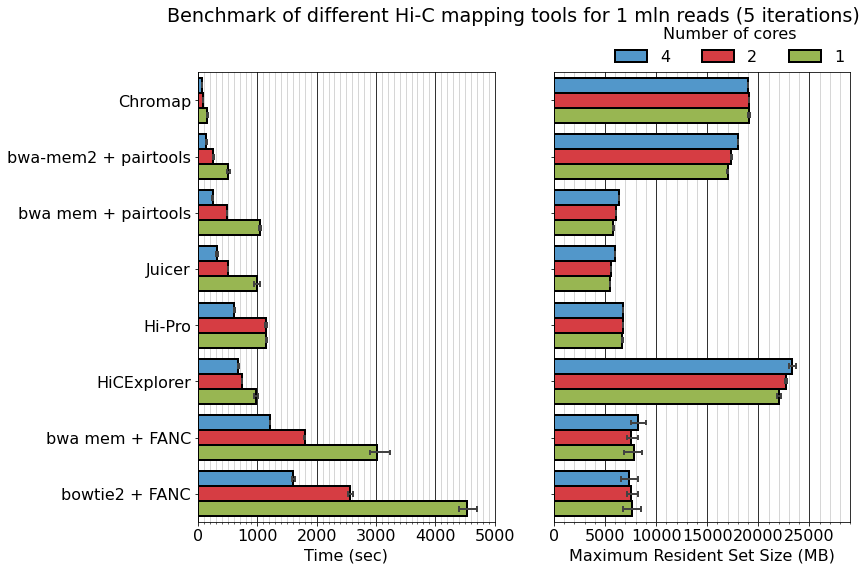

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

cmap = ['#3E9ADE', '#EF242B', '#9FC741']

style_dict = dict(
        orient='h',
        palette=cmap,
        edgecolor="k",
        linewidth=2.0,
        errwidth=2.0,
        capsize=0.07)

ax = axes[0]
sns.barplot(x="s", 
        y="util", 
        data=df.sort_values('util'),
        order=labels,
        hue='ncores',
        hue_order=[4,2,1],
        ax=ax,
        **style_dict
)
ax.set_ylabel('')
ax.set_xlabel('Time (sec)')
ax.set_yticklabels(labels_mod)
ax.set_axisbelow(True)
ax.grid(which='both', axis='x', color='k')
#ax.set_xscale('log')
ax.set_xlim([0, 5e3])
ax.set_xticks(np.arange(0, 5000, 100), minor=True)
ax.grid(which='minor', axis='x', alpha=0.2, color='k')
ax.get_legend().remove()

ax = axes[1]
sns.barplot(x="max_rss", 
        y="util", 
        data=df.sort_values('util'),
        order=labels,
        hue='ncores',
        hue_order=[4,2,1],
        ax=ax,
        **style_dict)

ax.set_ylabel('')
ax.set_xlabel('Maximum Resident Set Size (MB)')
ax.set_yticklabels(labels_mod)
ax.set_axisbelow(True)
ax.grid(which='both', axis='x', color='k')
ax.set_xticks(np.arange(0, 30000, 1000), minor=True)
ax.grid(which='minor', axis='x', alpha=0.2, color='k')

fig.suptitle('Benchmark of different Hi-C mapping tools for 1 mln reads (5 iterations)', y=0.99)

# (x, y, width, height)
bb = (fig.subplotpars.left, fig.subplotpars.top+0.002, fig.subplotpars.right-fig.subplotpars.left, 0.2)
ax.legend(bbox_to_anchor=bb, title="Number of cores", loc="lower right", ncol=3, borderaxespad=0., bbox_transform=fig.transFigure, frameon=False)

plt.savefig("benchmarking_1mln.pdf")

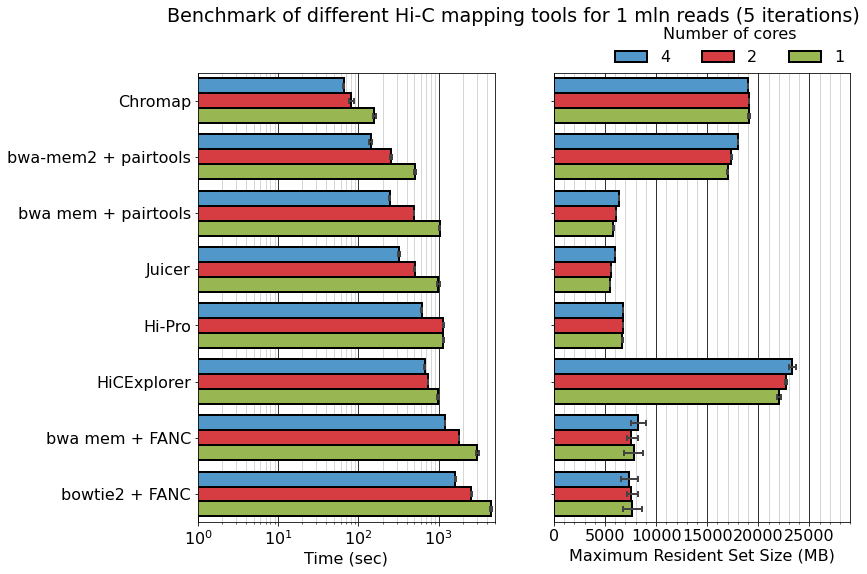

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)

cmap = ['#3E9ADE', '#EF242B', '#9FC741']

style_dict = dict(
        orient='h',
        palette=cmap,
        edgecolor="k",
        linewidth=2.0,
        errwidth=2.0,
        capsize=0.07)

ax = axes[0]
sns.barplot(x="s", 
        y="util", 
        data=df.sort_values('util'),
        order=labels,
        hue='ncores',
        hue_order=[4,2,1],
        ax=ax,
        **style_dict
)
ax.set_ylabel('')
ax.set_xlabel('Time (sec)')
ax.set_yticklabels(labels_mod)
ax.set_axisbelow(True)
ax.grid(which='both', axis='x', color='k')
ax.set_xscale('log')
ax.set_xlim([1, 5e3])
# ax.set_xticks(np.arange(0, 5000, 100), minor=True)
ax.grid(which='minor', axis='x', alpha=0.2, color='k')
ax.get_legend().remove()

ax = axes[1]
sns.barplot(x="max_rss", 
        y="util", 
        data=df.sort_values('util'),
        order=labels,
        hue='ncores',
        hue_order=[4,2,1],
        ax=ax,
        **style_dict)

ax.set_ylabel('')
ax.set_xlabel('Maximum Resident Set Size (MB)')
ax.set_yticklabels(labels_mod)
ax.set_axisbelow(True)
ax.grid(which='both', axis='x', color='k')
ax.set_xticks(np.arange(0, 30000, 1000), minor=True)
ax.grid(which='minor', axis='x', alpha=0.2, color='k')

fig.suptitle('Benchmark of different Hi-C mapping tools for 1 mln reads (5 iterations)', y=0.99)

# (x, y, width, height)
bb = (fig.subplotpars.left, fig.subplotpars.top+0.002, fig.subplotpars.right-fig.subplotpars.left, 0.2)
ax.legend(bbox_to_anchor=bb, title="Number of cores", loc="lower right", ncol=3, borderaxespad=0., bbox_transform=fig.transFigure, frameon=False)

plt.savefig("benchmarking_1mln_log.pdf")

In [10]:
df.to_csv('benchmarking_1mln.csv')